In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
# Load dataset
df = pd.read_csv('/content/telecom_call_drop_data.csv')

# Display first 5 rows
print("Data Head:\n", df.head())

# Display dataset information
print("\nDataset Info:\n")
df.info()

Data Head:
    cell_id  location  signal_strength  noise  latency  jitter  packet_loss  \
0       52        34              -81     19       42       8     3.897584   
1       93        45              -54     17       90      29     0.081002   
2       15         6              -94     14       84       8     4.091902   
3       72        37              -90     19       86      26     0.200694   
4       61        33              -81     13       59      17     4.449567   

   call_duration  drop_rate  
0            253   0.097366  
1             14   0.186979  
2            240   0.127417  
3            242   0.179734  
4            149   0.091302  

Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cell_id          1000 non-null   int64  
 1   location         1000 non-null   int64  
 2   signal_strength  1000 non-nul

In [3]:
# Check for missing values
print("Missing Values:\n", df.isnull().sum())

# Fill missing values with the mean of each column
df.fillna(df.mean(), inplace=True)

# Detect outliers using interquartile range (IQR)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Define outlier threshold (1.5 * IQR rule)
outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()
print("\nOutliers Detected:\n", outliers)

# Remove outliers (optional: based on business needs)
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Display dataset shape after removing outliers
print("\nDataset shape after outlier removal:", df.shape)

Missing Values:
 cell_id            0
location           0
signal_strength    0
noise              0
latency            0
jitter             0
packet_loss        0
call_duration      0
drop_rate          0
dtype: int64

Outliers Detected:
 cell_id            0
location           0
signal_strength    0
noise              0
latency            0
jitter             0
packet_loss        0
call_duration      0
drop_rate          0
dtype: int64

Dataset shape after outlier removal: (1000, 9)


In [4]:
# Encode categorical variables
encoder = LabelEncoder()

df['cell_id'] = encoder.fit_transform(df['cell_id'])
df['location'] = encoder.fit_transform(df['location'])

# Display transformed dataset
print("Transformed Data:\n", df.head())

Transformed Data:
    cell_id  location  signal_strength  noise  latency  jitter  packet_loss  \
0       51        33              -81     19       42       8     3.897584   
1       92        44              -54     17       90      29     0.081002   
2       14         5              -94     14       84       8     4.091902   
3       71        36              -90     19       86      26     0.200694   
4       60        32              -81     13       59      17     4.449567   

   call_duration  drop_rate  
0            253   0.097366  
1             14   0.186979  
2            240   0.127417  
3            242   0.179734  
4            149   0.091302  


In [5]:
# Create a new feature: Signal-to-Noise Ratio (SNR)
df['signal_to_noise_ratio'] = df['signal_strength'] / (df['noise'] + 1e-5)  # Adding small value to avoid division by zero

# Create another feature: Call Duration per Drop Rate
df['duration_per_drop'] = df['call_duration'] / (df['drop_rate'] + 1e-5)  # Avoid division by zero

# Display dataset with new features
print("Dataset with New Features:\n", df.head())


Dataset with New Features:
    cell_id  location  signal_strength  noise  latency  jitter  packet_loss  \
0       51        33              -81     19       42       8     3.897584   
1       92        44              -54     17       90      29     0.081002   
2       14         5              -94     14       84       8     4.091902   
3       71        36              -90     19       86      26     0.200694   
4       60        32              -81     13       59      17     4.449567   

   call_duration  drop_rate  signal_to_noise_ratio  duration_per_drop  
0            253   0.097366              -4.263156        2598.185684  
1             14   0.186979              -3.176469          74.870871  
2            240   0.127417              -6.714281        1883.428670  
3            242   0.179734              -4.736840        1346.362710  
4            149   0.091302              -6.230764        1631.772095  


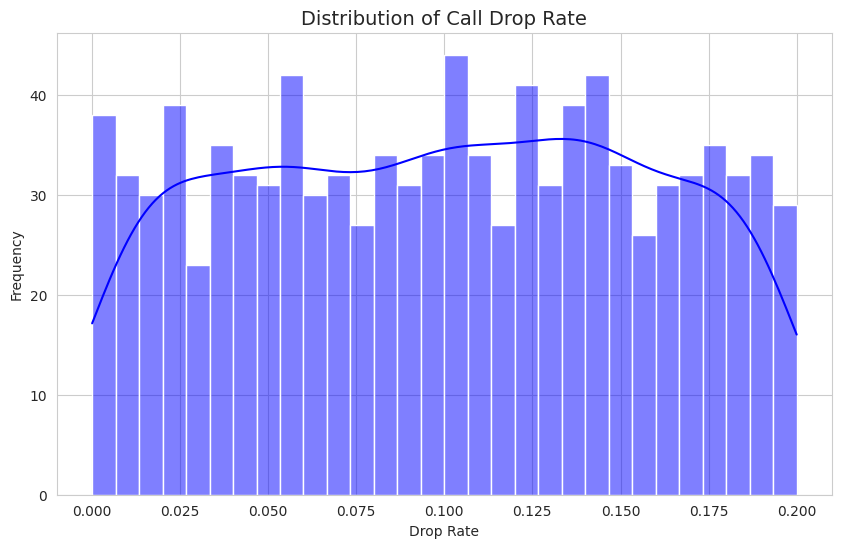

In [6]:
# Set style for plots
sns.set_style("whitegrid")

# 1. Distribution of Call Drop Rates
plt.figure(figsize=(10, 6))
sns.histplot(df['drop_rate'], bins=30, kde=True, color='blue')
plt.title("Distribution of Call Drop Rate", fontsize=14)
plt.xlabel("Drop Rate")
plt.ylabel("Frequency")
plt.show()

<ipython-input-7-42df5cc8a58b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['location'], y=df['drop_rate'], palette="Set2")


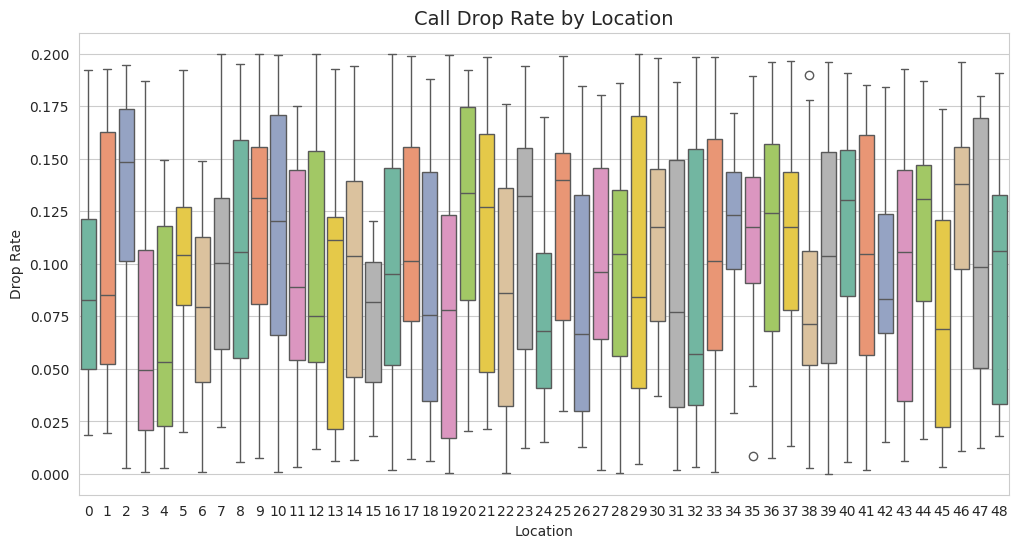

In [7]:
# 2. Call Drop Rate by Location
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['location'], y=df['drop_rate'], palette="Set2")
plt.title("Call Drop Rate by Location", fontsize=14)
plt.xlabel("Location")
plt.ylabel("Drop Rate")
plt.show()

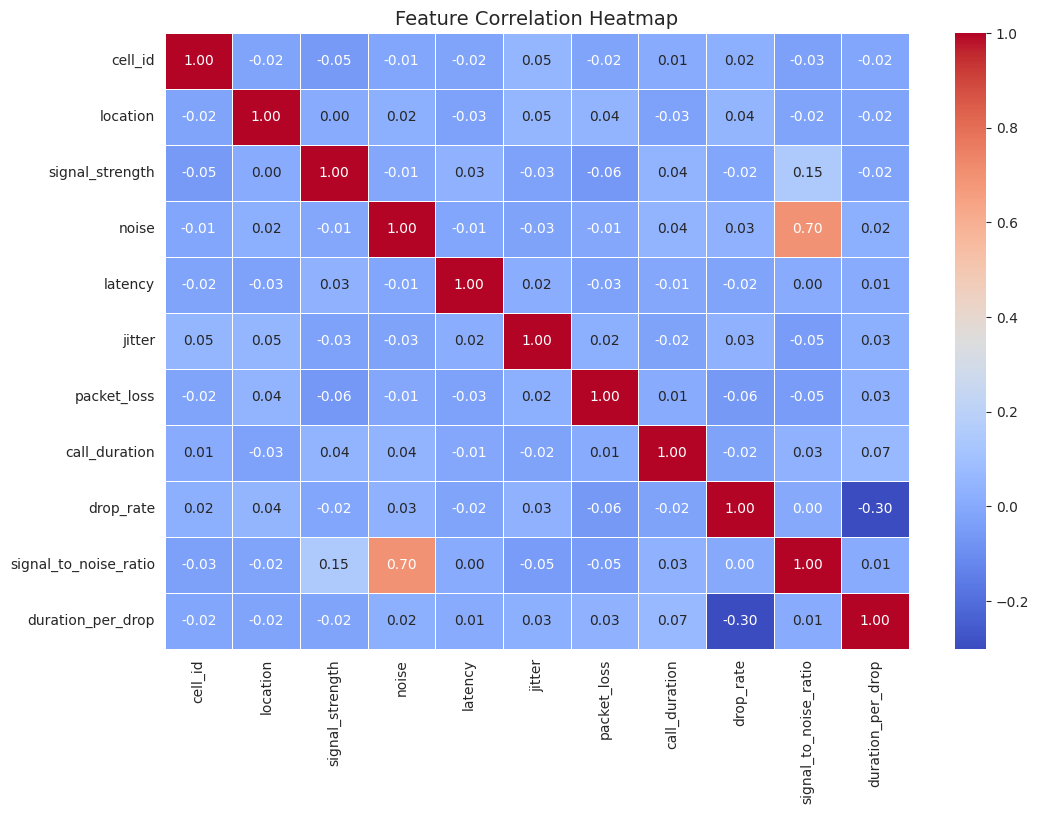

In [8]:
# 3. Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.show()

In [9]:
# Define features and target variable
X = df.drop(columns=['drop_rate'])  # Features
y = df['drop_rate'].apply(lambda x: 1 if x > 0.05 else 0)  # Convert drop rate into binary classification (1 = High drop rate, 0 = Low)

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": SVC(),
    "Gradient Boosting": GradientBoostingClassifier()
}

# Train models and store them
trained_models = {}

for name, model in models.items():
    model.fit(X_train, y_train)  # Train model
    trained_models[name] = model  # Store trained model
    print(f"{name} model trained successfully.")

Decision Tree model trained successfully.
SVM model trained successfully.
Gradient Boosting model trained successfully.


Evaluation for Decision Tree:
Accuracy: 0.98
Precision: 0.99
Recall: 0.99
F1 Score: 0.99
Confusion Matrix:


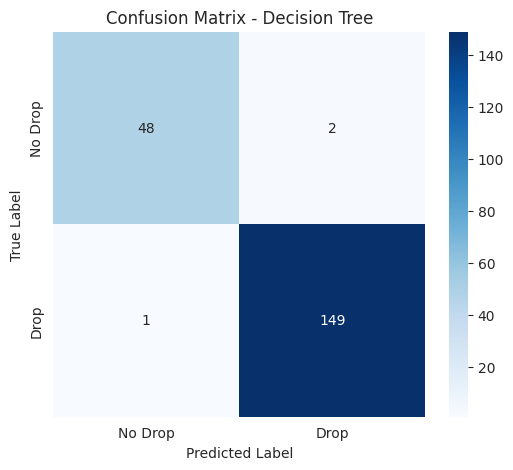

----------------------------------------
Evaluation for SVM:
Accuracy: 0.88
Precision: 0.86
Recall: 0.99
F1 Score: 0.92
Confusion Matrix:


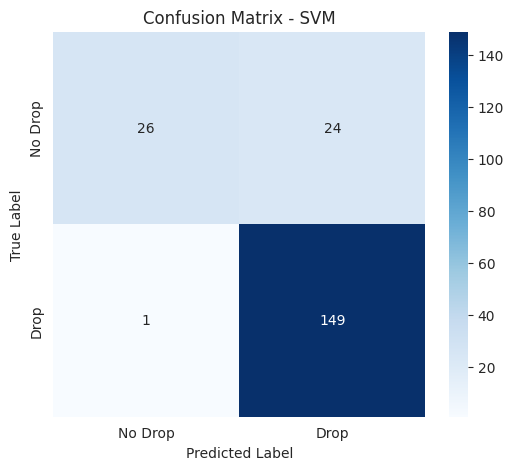

----------------------------------------
Evaluation for Gradient Boosting:
Accuracy: 0.98
Precision: 0.98
Recall: 0.99
F1 Score: 0.99
Confusion Matrix:


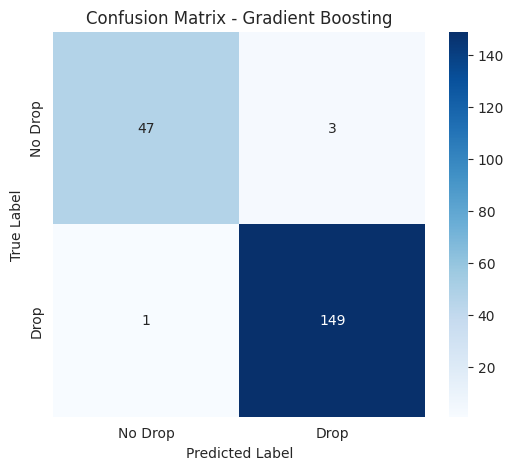

----------------------------------------


In [10]:
# Function to evaluate models
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)  # Make predictions

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"Evaluation for {model_name}:")
    print(f"Accuracy: {acc:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("Confusion Matrix:")

    # Display confusion matrix as a heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Drop', 'Drop'], yticklabels=['No Drop', 'Drop'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    print("-" * 40)

# Evaluate all trained models
for name, model in trained_models.items():
    evaluate_model(model, X_test, y_test, name)


<ipython-input-11-10fe06d844d4>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_df["Importance"], y=feature_importance_df["Feature"], palette="viridis")


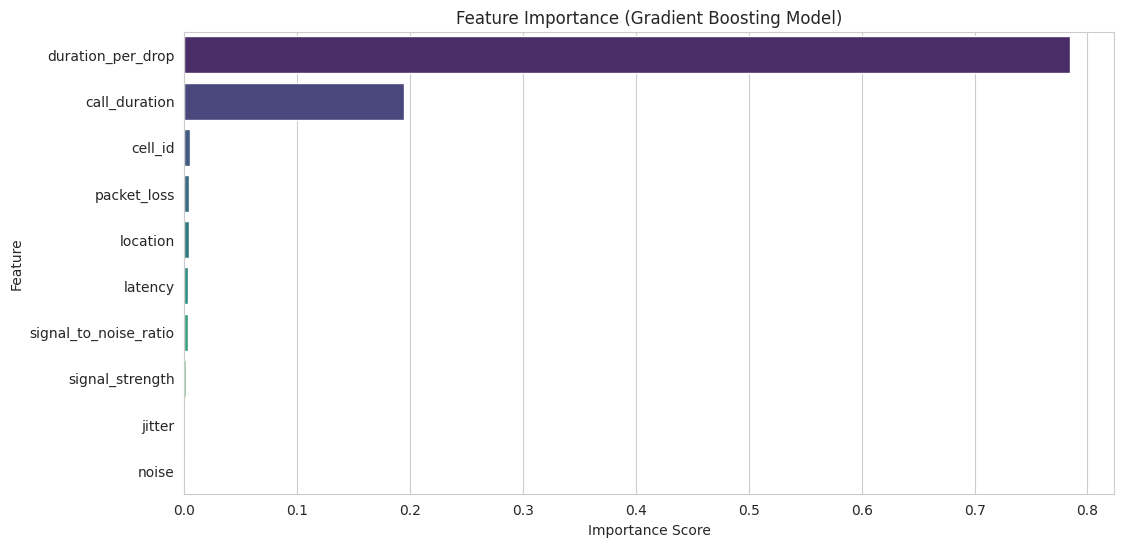

Top Locations with High Call Drop Rates:
 location
28    26
39    24
46    22
10    21
25    21
16    20
33    20
36    20
5     19
44    19
Name: count, dtype: int64


In [11]:
# Feature importance for Gradient Boosting model
importances = trained_models["Gradient Boosting"].feature_importances_

# Create DataFrame to display importance values
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance_df["Importance"], y=feature_importance_df["Feature"], palette="viridis")
plt.title("Feature Importance (Gradient Boosting Model)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# Identify high drop rate locations
high_drop_locations = df[df["drop_rate"] > 0.05]["location"].value_counts()

# Display locations with frequent call drops
print("Top Locations with High Call Drop Rates:\n", high_drop_locations.head(10))
